# ChartBook Plotting Gallery

This gallery demonstrates all chart types available in `chartbook.plotting` using
real economic data from FRED (Federal Reserve Economic Data).

Each example shows:
- How to create the chart
- Common customization options
- Best practices for different use cases

## Setup

First, let's import the required libraries and fetch some FRED data.

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

import chartbook

# For fetching FRED data
try:
    import pandas_datareader.data as web

    HAS_DATAREADER = True
except ImportError:
    HAS_DATAREADER = False
    print("pandas_datareader not installed. Using synthetic data.")

In [2]:
# Configuration
START_DATE = "2000-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")

# FRED series we'll use
FRED_SERIES = {
    "GDP": "GDP",  # Gross Domestic Product
    "UNRATE": "UNRATE",  # Unemployment Rate
    "CPIAUCSL": "CPIAUCSL",  # Consumer Price Index
    "FEDFUNDS": "FEDFUNDS",  # Federal Funds Rate
    "GS10": "GS10",  # 10-Year Treasury Rate
    "SP500": "SP500",  # S&P 500
    "DEXUSEU": "DEXUSEU",  # USD/EUR Exchange Rate
    "HOUST": "HOUST",  # Housing Starts
}

In [3]:
def fetch_fred_data(series_ids: list[str], start: str, end: str) -> pd.DataFrame:
    """Fetch data from FRED or generate synthetic data."""
    if HAS_DATAREADER:
        try:
            df = web.DataReader(series_ids, "fred", start, end)
            df = df.reset_index()
            df.columns = ["date"] + series_ids
            return df
        except Exception as e:
            print(f"Error fetching FRED data: {e}")
            print("Falling back to synthetic data.")

    # Generate synthetic data
    dates = pd.date_range(start=start, end=end, freq="MS")
    np.random.seed(42)

    data = {"date": dates}
    for series in series_ids:
        if series == "GDP":
            # Trending upward with some noise
            base = 10000 + np.arange(len(dates)) * 50
            data[series] = base + np.random.randn(len(dates)) * 200
        elif series == "UNRATE":
            # Oscillating between 3-10%
            data[series] = (
                5
                + 2 * np.sin(np.arange(len(dates)) * 0.1)
                + np.random.randn(len(dates)) * 0.5
            )
        elif series == "CPIAUCSL":
            # Trending upward (inflation)
            base = 170 + np.arange(len(dates)) * 0.5
            data[series] = base + np.random.randn(len(dates)) * 2
        elif series == "FEDFUNDS":
            # Interest rate cycles
            data[series] = (
                3
                + 2 * np.sin(np.arange(len(dates)) * 0.05)
                + np.random.randn(len(dates)) * 0.3
            )
            data[series] = np.clip(data[series], 0, 20)
        elif series == "GS10":
            # 10-year rate
            data[series] = (
                4
                + 1.5 * np.sin(np.arange(len(dates)) * 0.04)
                + np.random.randn(len(dates)) * 0.2
            )
            data[series] = np.clip(data[series], 0, 15)
        elif series == "SP500":
            # Stock market trending up with volatility
            base = 1000 * np.exp(np.arange(len(dates)) * 0.003)
            data[series] = base * (1 + np.random.randn(len(dates)) * 0.02)
        elif series == "DEXUSEU":
            # Exchange rate around 1.0-1.5
            data[series] = (
                1.2
                + 0.2 * np.sin(np.arange(len(dates)) * 0.03)
                + np.random.randn(len(dates)) * 0.02
            )
        elif series == "HOUST":
            # Housing starts in thousands
            data[series] = (
                1500
                + 500 * np.sin(np.arange(len(dates)) * 0.08)
                + np.random.randn(len(dates)) * 100
            )
            data[series] = np.clip(data[series], 400, 2500)
        else:
            data[series] = np.random.randn(len(dates)).cumsum()

    return pd.DataFrame(data)

In [4]:
# Fetch the data
print("Fetching economic data...")
economic_data = fetch_fred_data(
    ["GDP", "UNRATE", "CPIAUCSL", "FEDFUNDS", "GS10"], START_DATE, END_DATE
)
print(f"Loaded {len(economic_data)} rows of data")
economic_data.head()

Fetching economic data...


Loaded 312 rows of data


,date,GDP,UNRATE,CPIAUCSL,FEDFUNDS,GS10
0,2000-01-01,10002.179,4.0,169.3,5.45,6.66
1,2000-02-01,NaN,4.1,170.0,5.73,6.52
2,2000-03-01,NaN,4.0,171.0,5.85,6.26
3,2000-04-01,10247.720,3.8,170.9,6.02,5.99
4,2000-05-01,NaN,4.0,171.2,6.27,6.44


## Line Charts

Line charts are ideal for time series data. They show trends and patterns over time.

### Basic Line Chart

In [5]:
chartbook.plotting.line(
    economic_data.dropna(subset=["GDP"]),
    x="date",
    y="GDP",
    title="U.S. Gross Domestic Product",
    y_title="Billions of Dollars",
    source="FRED",
)

ChartResult(line, unsaved)

### Multi-Series Line Chart

In [6]:
chartbook.plotting.line(
    economic_data,
    x="date",
    y=["FEDFUNDS", "GS10"],
    title="Interest Rates Comparison",
    y_title="Percent",
    labels={"FEDFUNDS": "Fed Funds Rate", "GS10": "10-Year Treasury"},
    source="Federal Reserve Economic Data",
)

ChartResult(line, unsaved)

### Line Chart with Horizontal Reference Lines

In [7]:
chartbook.plotting.line(
    economic_data,
    x="date",
    y="UNRATE",
    title="U.S. Unemployment Rate",
    y_title="Percent",
    hlines=[
        {"y": 5.0, "color": "green", "dash": "dash", "label": "Natural Rate (~5%)"},
        # {"y": 10.0, "color": "red", "dash": "dot", "label": "Crisis Level"},
    ],
    source="Bureau of Labor Statistics via FRED",
)

ChartResult(line, unsaved)

### Line Chart with NBER Recession Shading

Add recession bars to provide economic context for time series data.

In [8]:
chartbook.plotting.line(
    economic_data.dropna(subset=["GDP"]),
    x="date",
    y="GDP",
    title="GDP with Recession Shading",
    y_title="Billions of Dollars",
    nber_recessions=True,
    source="FRED",
    note="Shaded areas indicate NBER recession periods",
)

ChartResult(line, unsaved)

## Bar Charts

Bar charts are useful for comparing values across categories or discrete time periods.

### Basic Bar Chart

In [9]:
# Create annual data for bar chart
annual_data = economic_data.copy()
annual_data["year"] = annual_data["date"].dt.year
annual_gdp = annual_data.groupby("year")["GDP"].mean().reset_index()
annual_gdp = annual_gdp.tail(10)  # Last 10 years

chartbook.plotting.bar(
    annual_gdp,
    x="year",
    y="GDP",
    title="Annual Average GDP (Last 10 Years)",
    y_title="Billions of Dollars",
    source="FRED",
)

ChartResult(bar, unsaved)

### Grouped Bar Chart

In [10]:
# Create comparison data
annual_rates = annual_data.groupby("year")[["FEDFUNDS", "GS10"]].mean().reset_index()
annual_rates = annual_rates.tail(10)

chartbook.plotting.bar(
    annual_rates,
    x="year",
    y=["FEDFUNDS", "GS10"],
    title="Annual Average Interest Rates",
    y_title="Percent",
    labels={"FEDFUNDS": "Fed Funds", "GS10": "10-Year Treasury"},
    source="FRED",
)

ChartResult(bar, unsaved)

### Stacked Bar Chart

In [11]:
# Create fake component data for stacking example
gdp_components = annual_gdp.copy()
gdp_components["consumption"] = gdp_components["GDP"] * 0.68
gdp_components["investment"] = gdp_components["GDP"] * 0.18
gdp_components["government"] = gdp_components["GDP"] * 0.17
gdp_components["net_exports"] = gdp_components["GDP"] * -0.03

chartbook.plotting.bar(
    gdp_components,
    x="year",
    y=["consumption", "investment", "government"],
    stacked=True,
    title="GDP Components (Simplified)",
    y_title="Billions of Dollars",
    labels={
        "consumption": "Consumption",
        "investment": "Investment",
        "government": "Government",
    },
    source="Illustrative example",
)

ChartResult(bar, unsaved)

## Scatter Plots

Scatter plots show relationships between two continuous variables.

### Basic Scatter Plot

In [12]:
# Use annual averages for cleaner scatter
scatter_data = annual_data.groupby("year")[["UNRATE", "CPIAUCSL"]].mean().reset_index()

# Calculate YoY inflation
scatter_data["inflation"] = scatter_data["CPIAUCSL"].pct_change() * 100
scatter_data = scatter_data.dropna()

chartbook.plotting.scatter(
    scatter_data,
    x="UNRATE",
    y="inflation",
    title="Phillips Curve: Unemployment vs Inflation",
    x_title="Unemployment Rate (%)",
    y_title="Inflation Rate (%)",
    source="FRED",
    note="Each point represents one year",
)

ChartResult(scatter, unsaved)

### Scatter Plot with Regression Line

In [13]:
chartbook.plotting.scatter(
    scatter_data,
    x="UNRATE",
    y="inflation",
    title="Phillips Curve with Regression Line",
    x_title="Unemployment Rate (%)",
    y_title="Inflation Rate (%)",
    regression_line=True,
    source="FRED",
)

ChartResult(scatter, unsaved)

### Scatter Plot with Size Mapping

In [14]:
# Add GDP as size dimension
scatter_gdp = annual_data.groupby("year")[["UNRATE", "GDP"]].mean().reset_index()
scatter_gdp["gdp_growth"] = scatter_gdp["GDP"].pct_change() * 100
scatter_gdp = scatter_gdp.dropna()
scatter_gdp = scatter_gdp.tail(20)  # Last 20 years

# Create decade column for coloring
scatter_gdp["decade"] = (scatter_gdp["year"] // 10) * 10
scatter_gdp["decade"] = scatter_gdp["decade"].astype(str) + "s"

chartbook.plotting.scatter(
    scatter_gdp,
    x="UNRATE",
    y="gdp_growth",
    size="GDP",
    color_by="decade",
    title="Unemployment vs GDP Growth",
    x_title="Unemployment Rate (%)",
    y_title="GDP Growth (%)",
    source="FRED",
    note="Bubble size represents GDP level",
)

ChartResult(scatter, unsaved)

## Area Charts

Area charts emphasize the magnitude of values over time, especially useful for showing
composition or cumulative totals.

### Stacked Area Chart

In [15]:
# Use the GDP components data
area_data = gdp_components.copy()

chartbook.plotting.area(
    area_data,
    x="year",
    y=["consumption", "investment", "government"],
    stacked=True,
    title="GDP Components Over Time",
    y_title="Billions of Dollars",
    labels={
        "consumption": "Consumption",
        "investment": "Investment",
        "government": "Government",
    },
    source="Illustrative example",
)

ChartResult(area, unsaved)

### Non-Stacked Area Chart

In [16]:
# Show interest rates as overlapping areas
rates_monthly = economic_data[["date", "FEDFUNDS", "GS10"]].dropna()
rates_monthly = rates_monthly.tail(120)  # Last 10 years

chartbook.plotting.area(
    rates_monthly,
    x="date",
    y=["FEDFUNDS", "GS10"],
    stacked=False,
    title="Interest Rate Trends",
    y_title="Percent",
    labels={"FEDFUNDS": "Fed Funds Rate", "GS10": "10-Year Treasury"},
    source="FRED",
)

ChartResult(area, unsaved)

## Pie Charts

Pie charts show proportional composition. Use sparingly and only when showing
parts of a whole.

### Basic Pie Chart

In [17]:
# GDP components as percentages
gdp_shares = pd.DataFrame(
    {
        "component": ["Consumption", "Investment", "Government", "Net Exports"],
        "share": [68, 18, 17, -3],
    }
)
gdp_shares["share_abs"] = gdp_shares["share"].abs()

chartbook.plotting.pie(
    gdp_shares,
    names="component",
    values="share_abs",
    title="GDP Composition by Component",
    source="Bureau of Economic Analysis",
)

ChartResult(pie, unsaved)

## Dual-Axis Charts

Dual-axis charts combine two different scales on the same plot. Use when comparing
series with different units or scales.

### Line + Line Dual Axis

In [18]:
dual_data = economic_data[["date", "GDP", "UNRATE"]].dropna()

chartbook.plotting.dual(
    dual_data,
    x="date",
    left_y="GDP",
    right_y="UNRATE",
    left_type="line",
    right_type="line",
    title="GDP vs Unemployment Rate",
    left_y_title="GDP (Billions $)",
    right_y_title="Unemployment Rate (%)",
    source="FRED",
)

ChartResult(dual_line_line, unsaved)

### Bar + Line Dual Axis

In [19]:
# GDP growth as bars, unemployment as line
gdp_growth = annual_data.groupby("year")[["GDP", "UNRATE"]].mean().reset_index()
gdp_growth["gdp_growth"] = gdp_growth["GDP"].pct_change() * 100
gdp_growth = gdp_growth.dropna().tail(15)

chartbook.plotting.dual(
    gdp_growth,
    x="year",
    left_y="gdp_growth",
    right_y="UNRATE",
    left_type="bar",
    right_type="line",
    title="GDP Growth vs Unemployment",
    left_y_title="GDP Growth (%)",
    right_y_title="Unemployment Rate (%)",
    source="FRED",
)

ChartResult(dual_bar_line, unsaved)

## Advanced Features

### Confidence Bands

In [20]:
# Create data with confidence intervals
forecast_data = economic_data[["date", "GDP"]].dropna().tail(60).copy()
forecast_data["upper"] = forecast_data["GDP"] * 1.05
forecast_data["lower"] = forecast_data["GDP"] * 0.95
forecast_data["forecast"] = forecast_data["GDP"] * (
    1 + np.random.randn(len(forecast_data)) * 0.01
)

chartbook.plotting.line(
    forecast_data,
    x="date",
    y="forecast",
    title="GDP with Confidence Interval",
    y_title="Billions of Dollars",
    bands=[
        {
            "y_upper": "upper",
            "y_lower": "lower",
            "color": "blue",
            "alpha": 0.2,
        }
    ],
    source="Illustrative forecast",
)

ChartResult(line, unsaved)

### Custom Shaded Regions

In [21]:
# Highlight a specific time period
recent_data = economic_data[["date", "UNRATE"]].dropna().tail(120)

chartbook.plotting.line(
    recent_data,
    x="date",
    y="UNRATE",
    title="Unemployment Rate with COVID Period Highlighted",
    y_title="Percent",
    shaded_regions=[
        {
            "x0": "2020-02-01",
            "x1": "2021-06-01",
            "color": "red",
            "alpha": 0.15,
            "label": "COVID-19 Impact",
        }
    ],
    source="Bureau of Labor Statistics via FRED",
)

ChartResult(line, unsaved)

### Vertical Reference Lines

In [22]:
chartbook.plotting.line(
    recent_data,
    x="date",
    y="UNRATE",
    title="Unemployment with Key Dates",
    y_title="Percent",
    vlines=[
        {"x": "2020-03-01", "color": "red", "dash": "dash", "label": "COVID Start"},
        {"x": "2022-03-01", "color": "green", "dash": "dash", "label": "Recovery"},
    ],
    source="FRED",
)

ChartResult(line, unsaved)

## Accessing Raw Figures

ChartBook returns a `ChartResult` object that provides access to the underlying
Plotly figure and lazily-created matplotlib objects for fine-grained customization.

### Plotly Figure Access

In [23]:
# Create a chart
result = chartbook.plotting.line(
    economic_data[["date", "GDP"]].dropna(),
    x="date",
    y="GDP",
    title="GDP (Customizable)",
)

# Access the Plotly figure
fig = result.figure

# Customize with Plotly API
fig.update_layout(
    title_font=dict(size=24, color="darkblue"),
    plot_bgcolor="white",
)
fig.update_traces(
    line=dict(width=3, color="navy"),
    fill="tozeroy",
    fillcolor="rgba(0, 0, 128, 0.1)",
)

# Display
# result.show()

### Matplotlib Access (for static exports)

Saved customized matplotlib figure to unemployment_custom.png


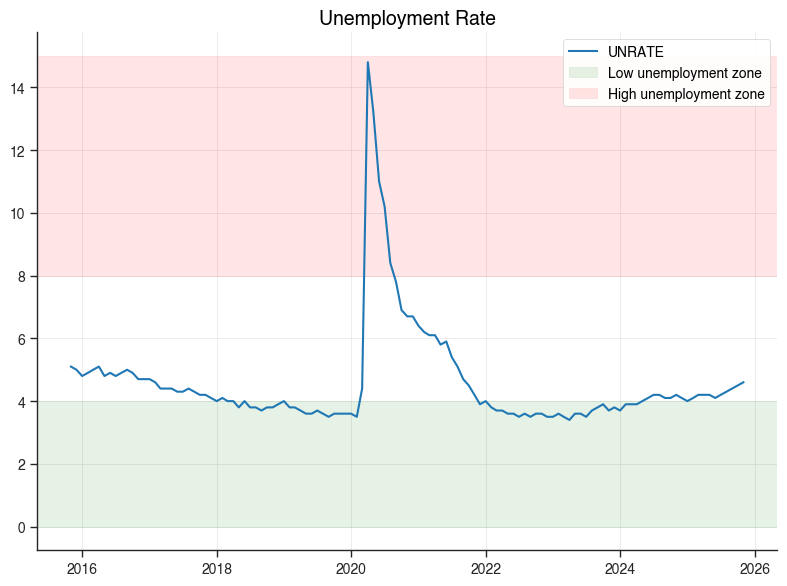

In [24]:
# Create a chart
result = chartbook.plotting.line(
    economic_data[["date", "UNRATE"]].dropna().tail(120),
    x="date",
    y="UNRATE",
    title="Unemployment Rate",
)

# Access matplotlib objects (lazily created)
ax = result.mpl_axes
fig = result.mpl_figure

# Customize with matplotlib API
ax.axhspan(0, 4, alpha=0.1, color="green", label="Low unemployment zone")
ax.axhspan(8, 15, alpha=0.1, color="red", label="High unemployment zone")
ax.legend(loc="upper right")
fig.tight_layout()

# Show the matplotlib figure
fig.savefig("unemployment_custom.png", dpi=150, bbox_inches="tight")
print("Saved customized matplotlib figure to unemployment_custom.png")

## Best Practices Summary

1. **Use `.show()` for exploration** - Quick inline display without saving files

2. **Use `.save()` for production** - Generates all formats with consistent naming

3. **Add context** - Use `source`, `note`, and `caption` for documentation

4. **Choose the right chart type**:
   - Line: Time series, trends
   - Bar: Comparisons, discrete categories
   - Scatter: Relationships between variables
   - Area: Composition, cumulative values
   - Pie: Parts of a whole (use sparingly)
   - Dual: Different scales/units

5. **Use overlays wisely**:
   - NBER recessions for economic context
   - Reference lines for targets/thresholds
   - Shaded regions for notable periods
   - Bands for uncertainty/confidence intervals